## Loading Data

In [2]:
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

import pandas as pd


In [3]:
SAVE_DIR = 'Plots'

In [4]:
Data_Dir = 'DATA'
df_train = pd.read_csv(os.path.join(Data_Dir, 'fashion-mnist_train.csv'))
df_test = pd.read_csv(os.path.join(Data_Dir, 'fashion-mnist_test.csv'))

In [6]:
label_map = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

In [12]:
def displayData_fashion(X,y,y_pred=None , save_img_dir=None):
    """
    Displays the data from X
    """
    import random
    # Create figure
    fig, ax = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize=(10, 12))
    for r in range(10):
        for c in range(10):
            res = random.sample(range(1, 5000), 1)
            ax[r, c].matshow(X[res][0].reshape((28,28)), cmap='binary')
            if y_pred is not None:
                if y[res][0] == y_pred[res][0]:
                    ax[r,c].title.set_color('green')
                    ax[r,c].title.set_text(label_map[y[res][0]])
                else:
                    ax[r,c].title.set_color('red')
                    ax[r,c].title.set_text(label_map[y_pred[res][0]])
            else:
                ax[r,c].title.set_text(label_map[y[res][0]])
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
        plt.tight_layout()
        if save_img_dir is not None:

            plt.savefig(os.path.join(save_img_dir))
    plt.show();

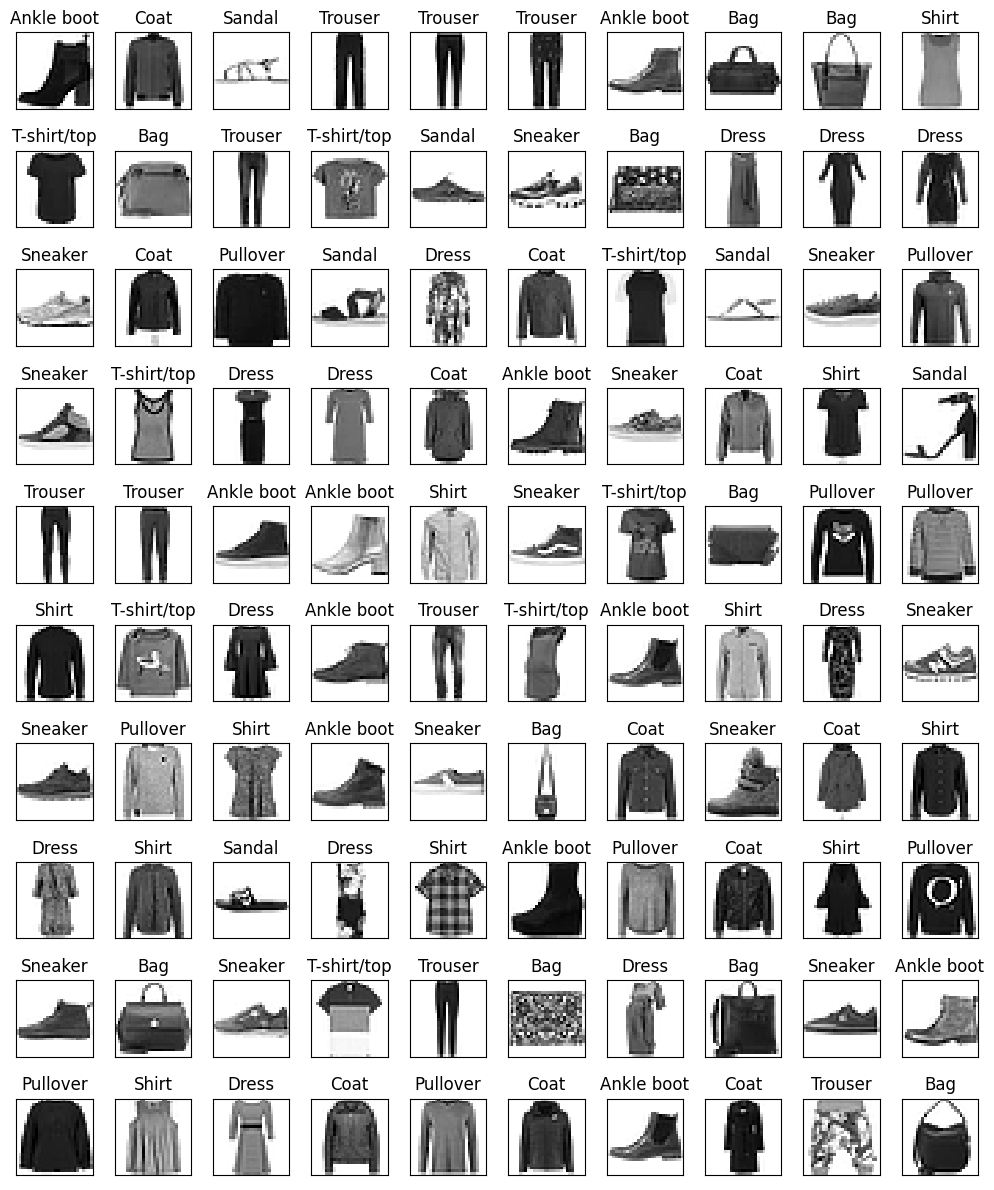

In [13]:
displayData_fashion(df_train.iloc[:,1:].values,df_train.iloc[:,0].values,save_img_dir=os.path.join(SAVE_DIR,'0601.png'))

## Preprocesing

The following preprocessing steps are performed:

1. Normalize the data
2. One-hot encode the labels
3. Train-test split

### Normalize the data

In [14]:
X = df_train.iloc[:,1:].values
y = df_train.iloc[:,0].values
X = np.insert(X, 0, 1, axis=1)

test_X = df_test.iloc[:,1:].values
test_X = np.insert(test_X, 0, 1, axis=1)
test_y = df_test.iloc[:,0].values

print(X.shape)

(10000, 785)


In [15]:
X = X/255
test_X = test_X/255

### One-hot encode the labels

In [16]:
def one_hot(y,c):
    y_hot = np.zeros((y.shape[0],c))
    for i in range(y.shape[0]):
        y_hot[i,y[i]] = 1
    return y_hot

In [17]:
y_one_hot = one_hot(y,10)
print(y_one_hot.shape)

(10000, 10)


### Train-test split

In [18]:
#train test split
ids = np.random.permutation(X.shape[0])
train_ids = ids[:int(X.shape[0]*0.8)]
test_ids = ids[int(X.shape[0]*0.8):]

X_train = X[train_ids]
y_train = y_one_hot[train_ids]

X_test = X[test_ids]
y_test = y_one_hot[test_ids]

assert X_train.shape[0] == y_train.shape[0]
assert X_train.shape[0]+X_test.shape[0] == X.shape[0] 

## Mathematical Formulation

The hypothesis function, for sigmoid regression has a form

$$
h(\theta) = \sigma(\mathbf{w}^TX) = y
$$

Here, $y$ is just a scalar.
Suppose there are $k$ classes, then, in softmax, the hypothesis function itself returns a vector with $\hat{y}\in \mathbb{R}^k$. That is,

$$
\mathbf{h(\theta)} = \text{softmax}(W^TX) = \hat{y}
$$

Note that I've written upper case $W$ instead of bold lower case $\mathbf{w}$ becuase in case of softmax, the weight is a matrix with dimension of $k\times n$.
The mathematical form of softmax is:

$$
 \phi(\mathbf{z}) = \frac{e^{\mathbf{z}}}{\sum_{j=1}^{k} e^{\mathbf{z}_{j}}}
$$

where

$$
\mathbf{z} = W^TX
$$

The loss function, used for softmax is the cross-entropy, defined as:

$$
J = -\sum_{c=1}^k {y}_{c}\log(\hat{y}_{c})/(2m)
$$

The update equation is the same:

$$
W_j:= W_j - \alpha  \frac{\partial J}{\partial W_j}
$$

The update equation is similar to that in binary classification:

$$
\begin{aligned}
W:=W - \alpha \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - \mathbf{y^{(i)}}) \mathbf{x}^{(i)}
\end{aligned}
$$


## Implementation

In [20]:
class SoftmaxBGD:
    def __init__(self,lr=0.1,n_iter=1000,see_loss=False, tol=None):
        self.lr = lr
        self.n_iter = n_iter
        self.w = None
        self.b = None
        self.loss = []
        self.tol = tol
        self.see_loss = see_loss
        self.loss_old = 1


    def softmax(self,z):

        return np.exp(z) / np.sum(np.exp(z),axis=1,keepdims=True)

    
    def loss_fun(self,y,y_softmax):
        return  -np.sum(y*np.log(y_softmax))*(1/(2*y.shape[0]))


    def grad(self,X,y,y_softmax):
        return np.dot(X.T,y_softmax-y )


    def fit(self,X,y):
        self.w = np.zeros((X.shape[1],y.shape[1]))
        for i in range(self.n_iter):
            z = np.dot(X,self.w)
            y_softmax = self.softmax(z)
            loss = self.loss_fun(y,y_softmax)
            self.loss.append(loss)
            self.w = self.w - (self.lr/X.shape[0])*self.grad(X,y,y_softmax)
            if self.see_loss:
                if (i+1)%1000 == 0:
                    print("Epoch: {}, Loss: {}".format(i+1,loss))
            if self.tol is not None:
                if (abs(self.loss_old-loss)/self.loss_old) < self.tol:
                    print("Converged at epoch: {}".format(i+1))
                    break
                self.loss_old = loss

                
    def predict(self,X):
        pred = self.softmax(np.dot(X,self.w))
        return np.argmax(pred,axis=1)
        
    def accuracy(self,y,y_pred):
        return np.mean(y_pred == y)
            
    def plot_loss(self, file_name):
        plt.plot(self.loss)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss vs Epoch")
        plt.savefig(os.path.join(SAVE_DIR,file_name))
            

In [21]:
bgd =  SoftmaxBGD(lr=0.1,n_iter=10000,see_loss=True)
bgd.fit(X_train,y_train)

Epoch: 1000, Loss: 0.23716906189038822
Epoch: 2000, Loss: 0.21359095533081615
Epoch: 3000, Loss: 0.20075306438501256
Epoch: 4000, Loss: 0.19189882598172678
Epoch: 5000, Loss: 0.18512175803620953
Epoch: 6000, Loss: 0.17961993277953503
Epoch: 7000, Loss: 0.17498213168979185
Epoch: 8000, Loss: 0.17096974558439584
Epoch: 9000, Loss: 0.1674318763241986
Epoch: 10000, Loss: 0.16426683351094293


In [22]:
y_pred_train= bgd.predict(X_train)
y_pred_test = bgd.predict(X_test)

In [23]:
train_acc = bgd.accuracy(np.argmax(y_train,axis=1),y_pred_train)
test_acc = bgd.accuracy(np.argmax(y_test,axis=1),y_pred_test)

print("Train Accuracy: {:.2f}%".format(train_acc*100))
print("Test Accuracy: {:.2f}%".format(test_acc*100))

Train Accuracy: 89.66%
Test Accuracy: 83.45%


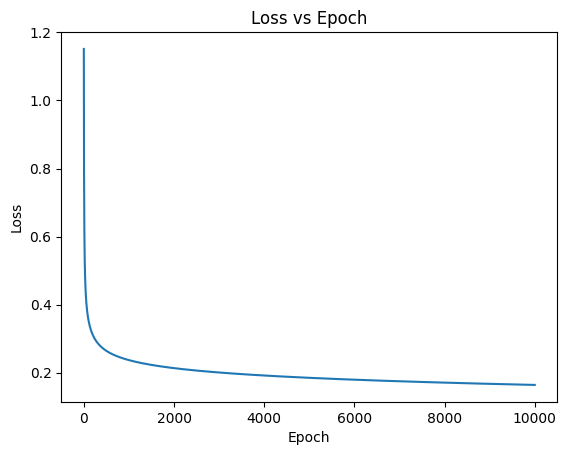

In [24]:
fig = bgd.plot_loss("0602.png")

In [ ]:
y_train.shape

(8000, 10)

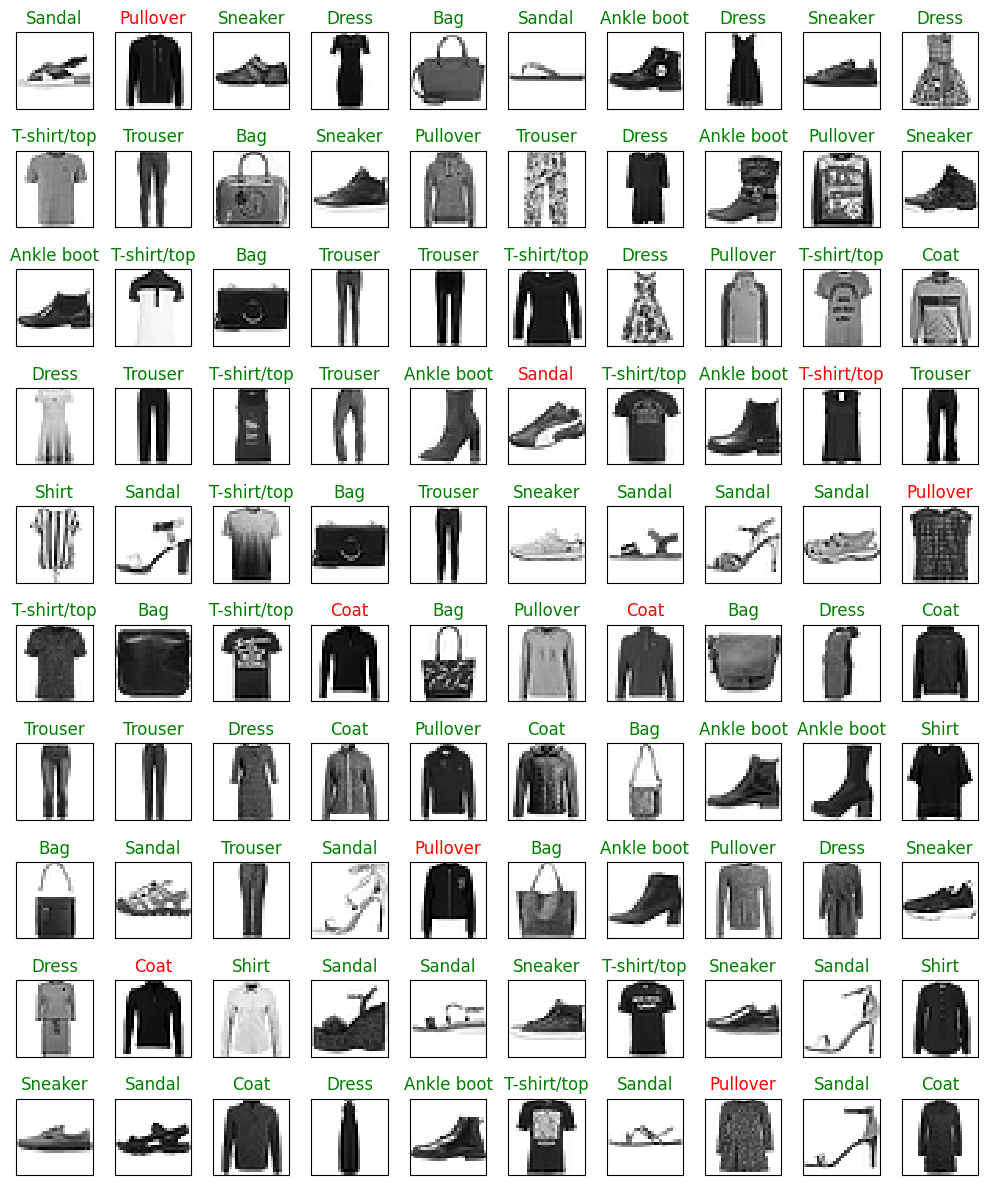

In [25]:
displayData_fashion(X_train[:, 1:],np.argmax(y_train, axis=1), y_pred_train, os.path.join(SAVE_DIR, '0603.png'))